In [1]:
!pip install pydot

In [2]:
import numpy as np
import pandas as pd
import scipy.io
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from decision_tree_starter import DecisionTree, RandomForest, preprocess, generate_submission
from save_csv import results_to_csv

SEED = 246810
np.random.seed(SEED)

In [3]:
def evaluate(model: DecisionTree | RandomForest, X_train, y_train, X_val, y_val):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    train_acc = np.sum(train_preds==y_train)/len(y_train)
    val_acc = np.sum(val_preds==y_val)/len(y_val)
    
    return train_acc, val_acc

In [4]:
# Data load
curr_dir = os.getcwd()
dataset_dir = os.path.join(curr_dir, 'datasets')
spam_data_path = os.path.join(dataset_dir, 'spam_data')
titanic_data_dir = os.path.join(dataset_dir, 'titanic')

spam_data = scipy.io.loadmat(os.path.join(spam_data_path, 'spam_data.mat'))
titanic_train = pd.read_csv(os.path.join(titanic_data_dir, 'titanic_training.csv'))
titanic_test = pd.read_csv(os.path.join(titanic_data_dir, 'titanic_testing_data.csv'))

In [18]:
# spam
features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription",
    "creative", "height", "featured", "differ", "width", "other",
    "energy", "business", "message", "volumes", "revision", "path",
    "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
    "square_bracket", "ampersand"
]
assert len(features) == 32

# Load spam data
path_train = 'datasets/spam_data/spam_data.mat'
data = scipy.io.loadmat(path_train)
X = data['training_data']
y = np.squeeze(data['training_labels'])
Z = data['test_data']
class_names = ["Ham", "Spam"]

# data split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

# decision tree
print("\n\nDecision Tree")
dt = DecisionTree(max_depth=5, feature_labels=features)
dt.fit(X_train, y_train)
train_acc, val_acc = evaluate(dt, X_train, y_train, X_val, y_val)
print(f"Spam Decision Tree:\nTrain Accuracy: {train_acc}  Validation Accuracy: {val_acc}\n")

# random forest
params = {
        "max_depth": 3,
        "min_samples_leaf": 10,
}
N = 100
print("\n\nRandom Forest")
rf = RandomForest(params, n=N, m=np.int_(np.sqrt(X_train.shape[1])))
rf.fit(X_train, y_train)
train_acc, val_acc = evaluate(rf, X_train, y_train, X_val, y_val)
print(f"Spam Random Forest:\nTrain Accuracy: {train_acc}  Validation Accuracy: {val_acc}\n")



Decision Tree
Spam Decision Tree:
Train Accuracy: 0.8068648779308678  Validation Accuracy: 0.7864734299516908



Random Forest
Spam Random Forest:
Train Accuracy: 0.7633550882281847  Validation Accuracy: 0.740096618357488



In [19]:
# Q4-5
# (1)
spam_index = np.where(y == 1)[0][0]
ham_index = np.where(y == 0)[0][0]

spam_point = X[spam_index]
ham_point = X[ham_index]

df = pd.DataFrame(
    data=[spam_point, ham_point], 
    columns=features,
    index=['spam', 'ham']
)
pd.set_option('display.max_columns', None)
df

,pain,private,bank,money,drug,spam,prescription,creative,height,featured,differ,width,other,energy,business,message,volumes,revision,path,meter,memo,planning,pleased,record,out,semicolon,dollar,sharp,exclamation,parenthesis,square_bracket,ampersand
spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


depth 5 is processed.
depth 10 is processed.
depth 15 is processed.
depth 20 is processed.
depth 25 is processed.
depth 30 is processed.
depth 35 is processed.
depth 40 is processed.
depth 45 is processed.
depth 50 is processed.


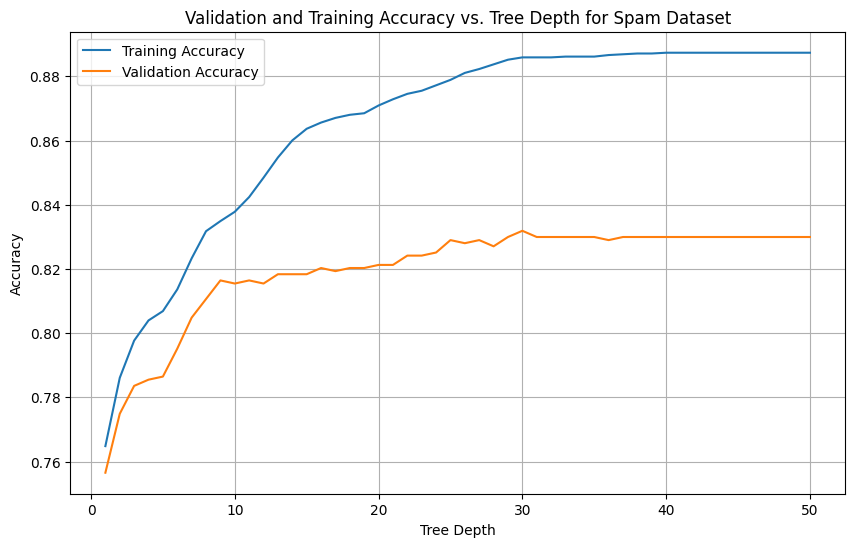

In [21]:

# (2)
train_accs = []
val_accs = []
max_depths = list(range(1, 51))

for depth in max_depths:
    dt = DecisionTree(max_depth=depth, feature_labels=features)
    dt.fit(X_train, y_train)

    train_acc, val_acc = evaluate(dt, X_train, y_train, X_val, y_val)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    del dt
    if depth%5 == 0:
        print(f"depth {depth} is processed.")

# Plotting the Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accs, label='Training Accuracy')
plt.plot(max_depths, val_accs, label='Validation Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy vs. Tree Depth for Spam Dataset')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# titanic
path_train = 'datasets/titanic/titanic_training.csv'
data = np.genfromtxt(path_train, delimiter=',', dtype=str)
path_test = 'datasets/titanic/titanic_testing_data.csv'
test_data = np.genfromtxt(path_test, delimiter=',', dtype=str)
y = data[1:, 0].astype(str)  # label = survived
class_names = ["Died", "Survived"]

labeled_idx = np.where(y != '')[0]
y = np.array(y[labeled_idx], dtype=float).astype(int)
X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
X = X[labeled_idx, :]
Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert X.shape[1] == Z.shape[1]
features = list(data[0, 1:]) + onehot_features

# data split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Decision Tree
print("\n\nDecision Tree")
dt = DecisionTree(max_depth=5, feature_labels=features)
dt.fit(X_train, y_train)
train_acc, val_acc = evaluate(dt, X_train, y_train, X_val, y_val)
print(f"Titanic Decision Tree:\nTrain Accuracy: {train_acc}  Validation Accuracy: {val_acc}\n")

# Random Forest
params = {
        "max_depth": 5,
        "min_samples_leaf": 10,
}
N = 100
print("\n\nRandom Forest")
rf = RandomForest(params, n=N, m=np.int_(np.sqrt(X_train.shape[1])))
rf.fit(X_train, y_train)
train_acc, val_acc = evaluate(rf, X_train, y_train, X_val, y_val)
print(f"Titanic Random Forest:\nTrain Accuracy: {train_acc}  Validation Accuracy: {val_acc}\n")



Decision Tree
Titanic Decision Tree:
Train Accuracy: 0.8297872340425532  Validation Accuracy: 0.77



Random Forest
Titanic Random Forest:
Train Accuracy: 0.818523153942428  Validation Accuracy: 0.765



## Kaggle

### Spam

In [9]:
# data load
def shuffle_idx(X, y):
    idx = np.arange(X.shape[0])
    idx = np.random.choice(idx, size=X.shape[0], replace=False)
    return X[idx, :], y[idx]

features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription",
    "creative", "height", "featured", "differ", "width", "other",
    "energy", "business", "message", "volumes", "revision", "path",
    "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
    "square_bracket", "ampersand"
]
assert len(features) == 32

# Load spam data
path_train = 'datasets/spam_data/spam_data.mat'
data = scipy.io.loadmat(path_train)
X_s = data['training_data']
y_s = np.squeeze(data['training_labels'])
test_s = data['test_data']
class_names = ["Ham", "Spam"]

X_s, y_s = shuffle_idx(X_s, y_s)

In [10]:
# decision tree
def cv_for_dt(dt, X, y, gini, k=5):
    val_acc_sum = 0.0
    val_size = int(1/k*X.shape[0])
    prev_idx = 0
    for _ in range(k):
        curr_idx = prev_idx+val_size
        X_val = X[prev_idx:curr_idx, :]
        y_val = y[prev_idx:curr_idx]
        X_train = np.concatenate([X[0:prev_idx, :], X[curr_idx:, :]], axis=0)
        y_train = np.concatenate([y[0:prev_idx], y[curr_idx:]], axis=0)
        
        dt.fit(X_train, y_train, gini)
        pred = dt.predict(X_val)
        val_acc_sum += accuracy_score(y_val, pred)
        prev_idx = curr_idx
    
    return val_acc_sum / k
        
print(f"{'='*20} Spam {'='*20}")

max_depths = [5, 10, 15, 20, 25, 30, 35]
ginis = [True, False]
best_score = 0
best_dt = None
for max_depth in max_depths:
    for gini in ginis:
        dt = DecisionTree(max_depth, features)
        score = cv_for_dt(dt, X_s, y_s, gini)
        if best_score < score:
            best_score = score
            best_dt = dt
        
print(f"\nDecision Tree:\nBest Score: {best_score}\nBest Model: depth={best_dt.max_depth}, gini={gini}")


# random forest
ccp_alpha = 0.001  # for pruning
max_depths = [5, 10, None]
min_samples_splits = [2, 5, 8]
min_samples_leaves = [1, 3, 5]
best_score = 0
best_rf = None

for N in np.arange(200, 99, -20):
    for max_depth in max_depths:
        for min_samples_split in min_samples_splits:
            for min_samples_leaf in min_samples_leaves:
                params = {
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'ccp_alpha': ccp_alpha
                }
                rf = RandomForest(params, N, np.int_(np.sqrt(X_s.shape[1])))
                score = np.mean(cross_val_score(rf, X_s, y_s))
                if best_score < score:
                    best_score = score
                    best_rf = rf
                    
print(f"\nRandom Forest:\nBest Score: {best_score}\nBest Model: {best_rf.get_params()}")


==================== Spam ====================

Decision Tree:
Best Score: 0.8263056092843326
Best Model: depth=25, gini=False

Random Forest:
Best Score: 0.8348781057569216
Best Model: {'m': np.int64(5), 'n': np.int64(100), 'params': {'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 1, 'ccp_alpha': 0.001, 'max_features': np.int64(5)}}


In [13]:
# save prediction
params = best_rf.get_params()['params']
model_s = RandomForest(params, n=100, m=np.int_(np.sqrt(X_s.shape[1])))
model_s.fit(X_s, y_s)
pred = model_s.predict(test_s)
generate_submission(test_s, pred, dataset='spam')

### Titanic

In [14]:
# data load
def shuffle_idx(X, y):
    idx = np.arange(X.shape[0])
    idx = np.random.choice(idx, size=X.shape[0], replace=False)
    return X[idx, :], y[idx]

path_train = 'datasets/titanic/titanic_training.csv'
data = np.genfromtxt(path_train, delimiter=',', dtype=str)
path_test = 'datasets/titanic/titanic_testing_data.csv'
test_data = np.genfromtxt(path_test, delimiter=',', dtype=str)
y_t = data[1:, 0].astype(str)  # label = survived
class_names = ["Died", "Survived"]

labeled_idx = np.where(y_t != '')[0]
y_t = np.array(y_t[labeled_idx], dtype=float).astype(int)
X_t, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
X_t = X_t[labeled_idx, :]
test_t, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert X_t.shape[1] == test_t.shape[1]
features = list(data[0, 1:]) + onehot_features

X_t, y_t = shuffle_idx(X_t, y_t)

In [15]:
# decision tree
def cv_for_dt(dt, X, y, gini, k=5):
    val_acc_sum = 0.0
    val_size = int(1/k*X.shape[0])
    prev_idx = 0
    for _ in range(k):
        curr_idx = prev_idx+val_size
        X_val = X[prev_idx:curr_idx, :]
        y_val = y[prev_idx:curr_idx]
        X_train = np.concatenate([X[0:prev_idx, :], X[curr_idx:, :]], axis=0)
        y_train = np.concatenate([y[0:prev_idx], y[curr_idx:]], axis=0)
        
        dt.fit(X_train, y_train, gini)
        pred = dt.predict(X_val)
        val_acc_sum += accuracy_score(y_val, pred)
        prev_idx = curr_idx
    
    return val_acc_sum / k

print(f"{'='*20} Titanic {'='*20}")

max_depths = [2, 3, 4, 5, 6, 7, 8, 15]
ginis = [True, False]
best_score = 0
best_dt = None
for max_depth in max_depths:
    for gini in ginis:
        dt = DecisionTree(max_depth, features)
        score = cv_for_dt(dt, X_t, y_t, gini)
        if best_score < score:
            best_score = score
            best_dt = dt
        
print(f"\nDecision Tree:\nBest Score: {best_score}\nBest Model: depth={best_dt.max_depth}, gini={gini}")


# random forest
ccp_alpha = 0.001  # for pruning
max_depths = [5, 10, None]
min_samples_splits = [2, 5, 8]
min_samples_leaves = [1, 3, 5]
best_score = 0
best_rf = None

for N in np.arange(200, 99, -20):
    for max_depth in max_depths:
        for min_samples_split in min_samples_splits:
            for min_samples_leaf in min_samples_leaves:
                params = {
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'ccp_alpha': ccp_alpha
                }
                rf = RandomForest(params, N, 5)  # tuned to 5 instead of 3
                score = np.mean(cross_val_score(rf, X_t, y_t))
                if best_score < score:
                    best_score = score
                    best_rf = rf
                    
print(f"\nRandom Forest:\nBest Score: {best_score}\nBest Model: {best_rf.get_params()}")

==================== Titanic ====================

Decision Tree:
Best Score: 0.7969849246231155
Best Model: depth=6, gini=False

Random Forest:
Best Score: 0.8138592964824122
Best Model: {'m': 5, 'n': np.int64(200), 'params': {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'ccp_alpha': 0.001, 'max_features': 5}}


In [16]:
# save prediction
params = best_rf.get_params()['params']
model_t = RandomForest(params, n=200, m=5)
model_t.fit(X_t, y_t)
pred = model_t.predict(test_t)
generate_submission(test_t, pred, dataset='titanic')